# Installing required Libraries

In [1]:
pip install keras torch torchvision seaborn tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Importing libraries
Note: Training was done on lightning.ai for better compute speed

In [48]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import mnist, fashion_mnist
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [49]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


CUDA available: True
Device name: NVIDIA L40S


# Helper functions

In [50]:
torch.manual_seed(42)
np.random.seed(42)

def show_confusion(cm, labels, title='Confusion Matrix'):
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


## Importing the dataset and reshaping it 

In [51]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X.reshape(-1,784)
test_X = test_X.reshape(-1, 784)
train_X = torch.from_numpy(train_X).float().reshape(-1, 784) / 255
train_y = torch.from_numpy(train_y).to(torch.int64)

test_X = torch.from_numpy(test_X).float().reshape(-1,784) / 255
test_y = torch.from_numpy(test_y).to(torch.int64)


# Helper functions

In [52]:
def evaluate_model(model, X_test, y_test, device='cpu'):
    model.eval()
    with torch.no_grad():
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)
        loss = F.cross_entropy(outputs, y_test).item()
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_true = y_test.cpu().numpy()
    acc = accuracy_score(y_true, preds)
    f1 = f1_score(y_true, preds, average='macro')
    cm = confusion_matrix(y_true, preds)
    return preds, acc, f1, cm, loss

In [53]:
def summary(name, acc, f1, cm, train_losses=None):
    print(f"\n{name}")
    print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}")
    show_confusion(cm, list(range(10)), title=f"{name} Confusion Matrix")

    if train_losses is not None:
        plt.figure(figsize=(7, 5))
        plt.plot(train_losses, label="Training Loss", linewidth=2)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"Training Loss vs Epochs - {name}")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

In [ ]:
def visualize_tsne(model, X, y, trained=True, device='cpu'):
    model.eval()
    X, y = X.to(device), y.cpu().numpy()
    with torch.no_grad():
        x = F.relu(model.fc1(X))
        layer2_out = model.fc2(x).cpu().numpy()

    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(layer2_out)

    plt.figure(figsize=(10, 6))
    num_classes = len(np.unique(y))
    for i in range(num_classes):
        indices = (y == i)
        plt.scatter(
            tsne_results[indices, 0],
            tsne_results[indices, 1],
            label=i,
            alpha=0.5
        )

    plt.legend(title="Class")
    plt.title(f"t-SNE (20-neuron layer) - {'Trained' if trained else 'Untrained'} Model")
    plt.tight_layout()
    plt.show()


# Defining the MLP

In [55]:
class MLP_relu(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(len(x), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [56]:
class MLP_sigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(len(x), -1)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return self.fc3(x)

In [57]:
def train_mlp(model, X_train, y_train, epochs=100, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    return train_losses

Using Cross Entropy Loss and ReLU


Training MLP...
Epoch 1/1000, Loss: 2.3110
Epoch 2/1000, Loss: 2.2992
Epoch 3/1000, Loss: 2.2862
Epoch 4/1000, Loss: 2.2712
Epoch 5/1000, Loss: 2.2543
Epoch 6/1000, Loss: 2.2358
Epoch 7/1000, Loss: 2.2162
Epoch 8/1000, Loss: 2.1962
Epoch 9/1000, Loss: 2.1763
Epoch 10/1000, Loss: 2.1564
Epoch 11/1000, Loss: 2.1361
Epoch 12/1000, Loss: 2.1151
Epoch 13/1000, Loss: 2.0936
Epoch 14/1000, Loss: 2.0715
Epoch 15/1000, Loss: 2.0489
Epoch 16/1000, Loss: 2.0259
Epoch 17/1000, Loss: 2.0023
Epoch 18/1000, Loss: 1.9784
Epoch 19/1000, Loss: 1.9540
Epoch 20/1000, Loss: 1.9293
Epoch 21/1000, Loss: 1.9043
Epoch 22/1000, Loss: 1.8790
Epoch 23/1000, Loss: 1.8533
Epoch 24/1000, Loss: 1.8274
Epoch 25/1000, Loss: 1.8012
Epoch 26/1000, Loss: 1.7747
Epoch 27/1000, Loss: 1.7479
Epoch 28/1000, Loss: 1.7210
Epoch 29/1000, Loss: 1.6938
Epoch 30/1000, Loss: 1.6665
Epoch 31/1000, Loss: 1.6391
Epoch 32/1000, Loss: 1.6115
Epoch 33/1000, Loss: 1.5839
Epoch 34/1000, Loss: 1.5562
Epoch 35/1000, Loss: 1.5285
Epoch 36/100

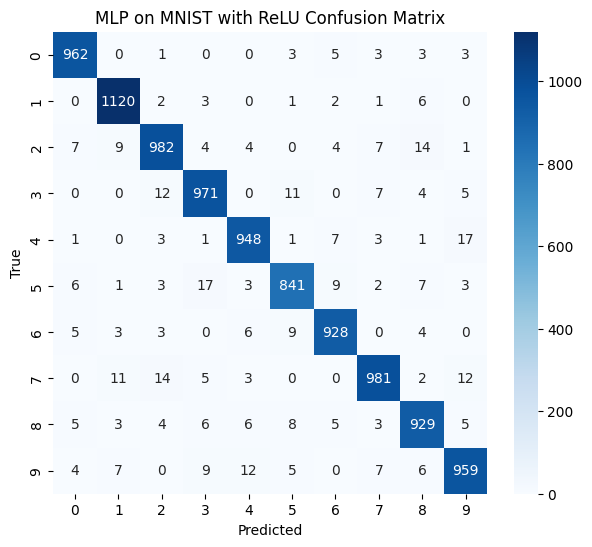

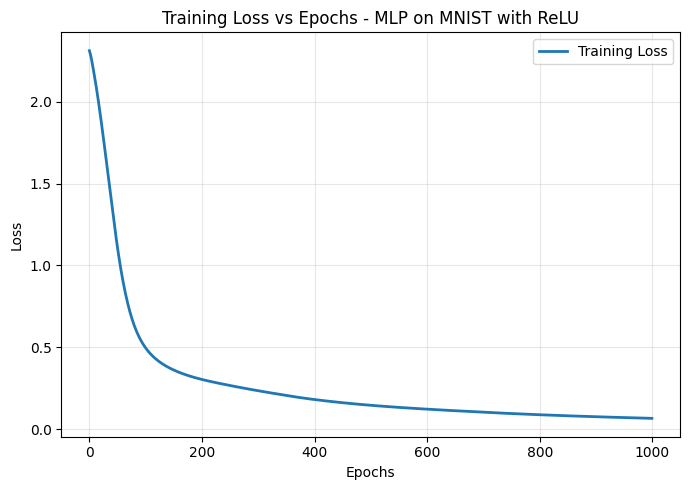

Test Loss: 0.1322


In [58]:
mlp_relu = MLP_relu().to(device)
print("\nTraining MLP...")
train_losses = train_mlp(mlp_relu, train_X.to(device), train_y.to(device), epochs=1000)

preds, acc, f1, cm, test_loss = evaluate_model(mlp_relu, test_X, test_y, device)
summary("MLP on MNIST with ReLU", acc, f1, cm, train_losses)
print(f"Test Loss: {test_loss:.4f}")

Using Cross Entropy and Sigmoid


Training MLP...
Epoch 1/1000, Loss: 2.3312
Epoch 2/1000, Loss: 2.3266
Epoch 3/1000, Loss: 2.3222
Epoch 4/1000, Loss: 2.3181
Epoch 5/1000, Loss: 2.3141
Epoch 6/1000, Loss: 2.3103
Epoch 7/1000, Loss: 2.3066
Epoch 8/1000, Loss: 2.3031
Epoch 9/1000, Loss: 2.2998
Epoch 10/1000, Loss: 2.2967
Epoch 11/1000, Loss: 2.2936
Epoch 12/1000, Loss: 2.2907
Epoch 13/1000, Loss: 2.2879
Epoch 14/1000, Loss: 2.2852
Epoch 15/1000, Loss: 2.2826
Epoch 16/1000, Loss: 2.2800
Epoch 17/1000, Loss: 2.2775
Epoch 18/1000, Loss: 2.2750
Epoch 19/1000, Loss: 2.2726
Epoch 20/1000, Loss: 2.2701
Epoch 21/1000, Loss: 2.2677
Epoch 22/1000, Loss: 2.2652
Epoch 23/1000, Loss: 2.2628
Epoch 24/1000, Loss: 2.2603
Epoch 25/1000, Loss: 2.2578
Epoch 26/1000, Loss: 2.2553
Epoch 27/1000, Loss: 2.2528
Epoch 28/1000, Loss: 2.2503
Epoch 29/1000, Loss: 2.2477
Epoch 30/1000, Loss: 2.2450
Epoch 31/1000, Loss: 2.2424
Epoch 32/1000, Loss: 2.2397
Epoch 33/1000, Loss: 2.2370
Epoch 34/1000, Loss: 2.2342
Epoch 35/1000, Loss: 2.2314
Epoch 36/100

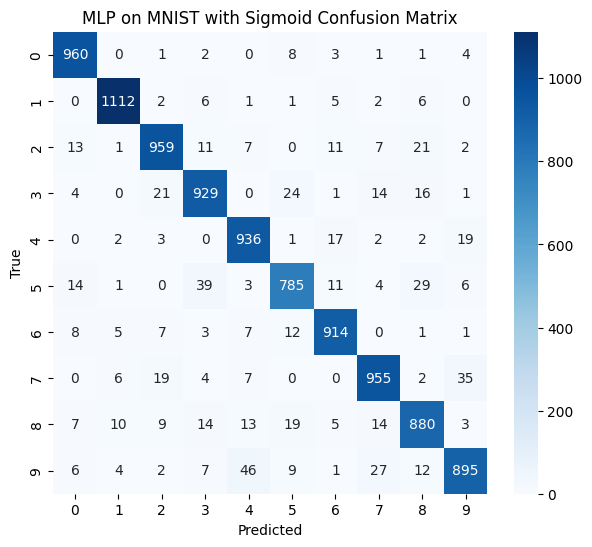

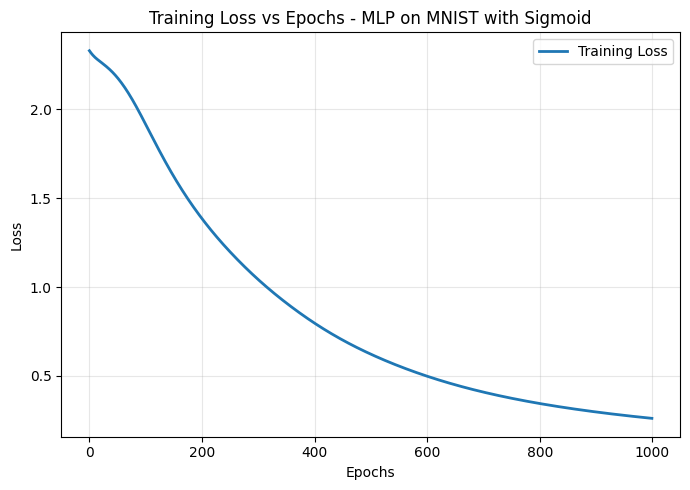

Test Loss: 0.2811


In [59]:
mlp_sigmoid = MLP_sigmoid().to(device)
print("\nTraining MLP...")
train_losses = train_mlp(mlp_sigmoid, train_X.to(device), train_y.to(device), epochs=1000)

preds, acc, f1, cm, test_loss = evaluate_model(mlp_sigmoid, test_X, test_y, device)
summary("MLP on MNIST with Sigmoid", acc, f1, cm, train_losses)
print(f"Test Loss: {test_loss:.4f}")


Random Forest
Accuracy: 0.9704, F1-score: 0.9702


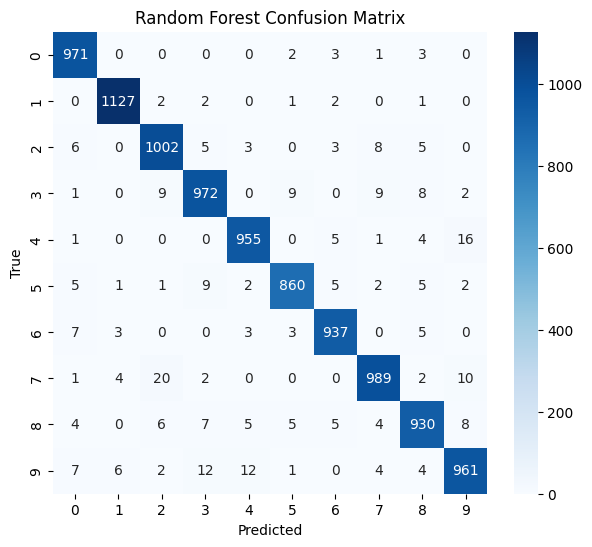


Logistic Regression
Accuracy: 0.9256, F1-score: 0.9245


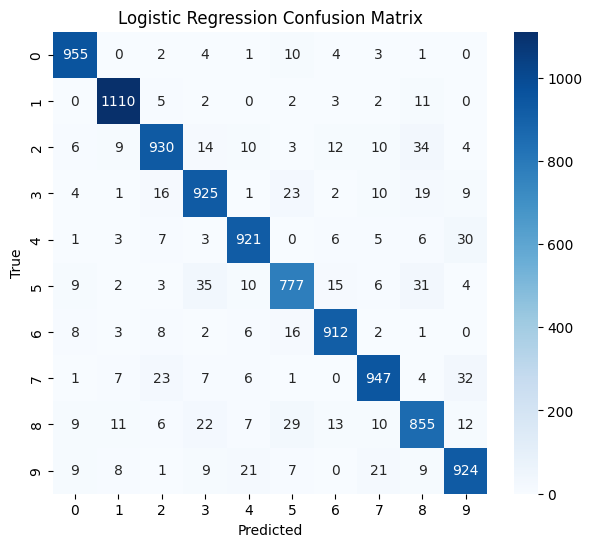

In [60]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_X, train_y)
rf_preds = rf.predict(test_X)
rf_acc = accuracy_score(test_y, rf_preds)
rf_f1 = f1_score(test_y, rf_preds, average='macro')
rf_cm = confusion_matrix(test_y, rf_preds)
summary("Random Forest", rf_acc, rf_f1, rf_cm)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_X, train_y)
log_preds = log_reg.predict(test_X)
log_acc = accuracy_score(test_y, log_preds)
log_f1 = f1_score(test_y, log_preds, average='macro')
log_cm = confusion_matrix(test_y, log_preds)
summary("Logistic Regression", log_acc, log_f1, log_cm)

MLP untrained with relu


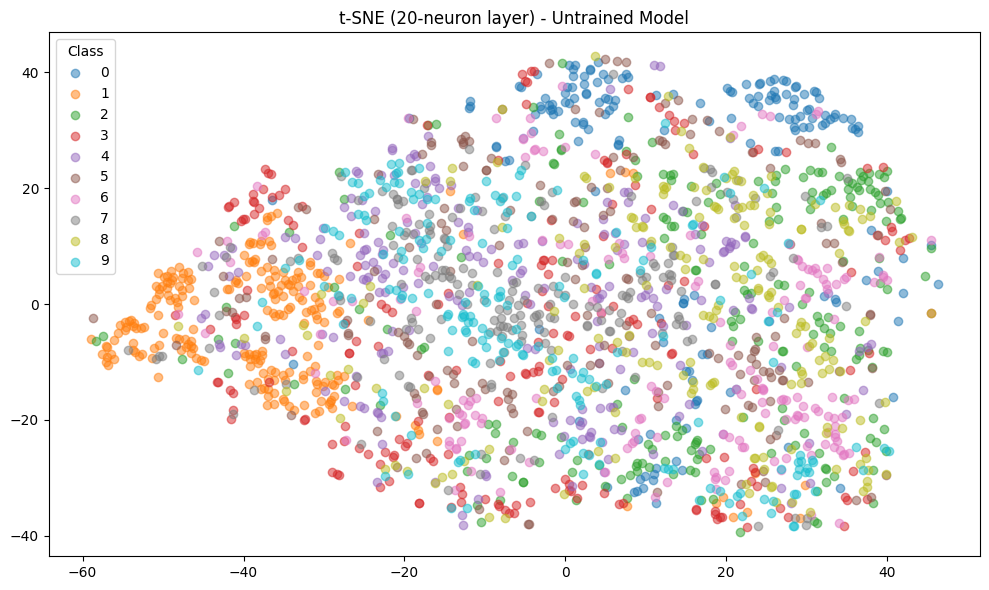

MLP untrained with sigmoid


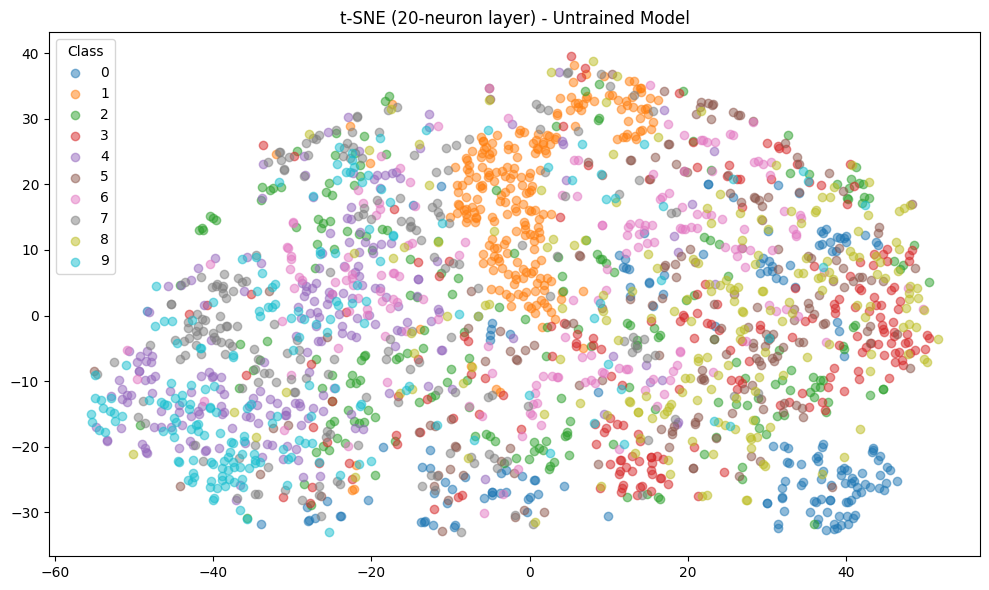

MLP trained with relu


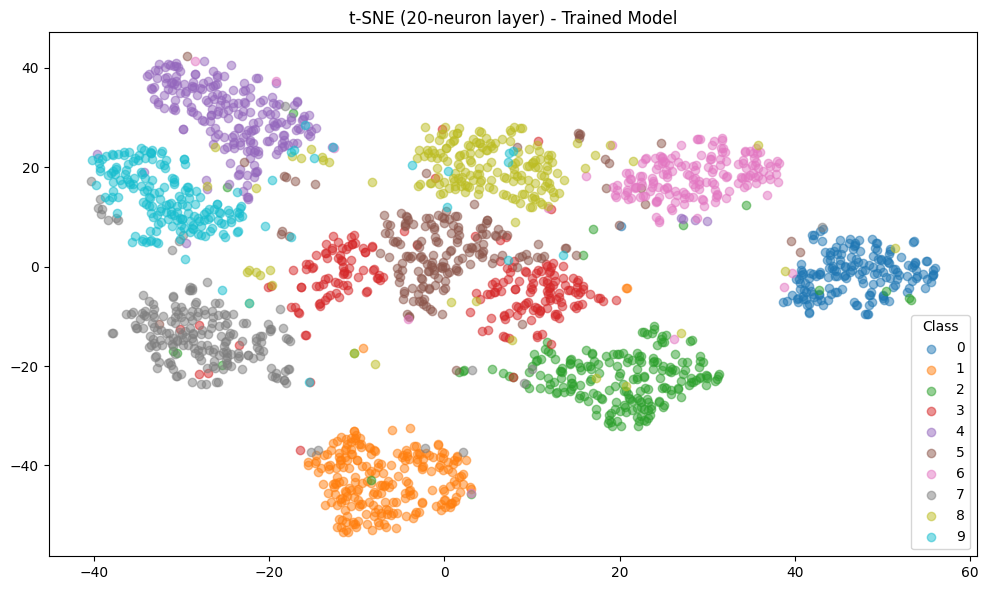

MLP trained with sigmoid


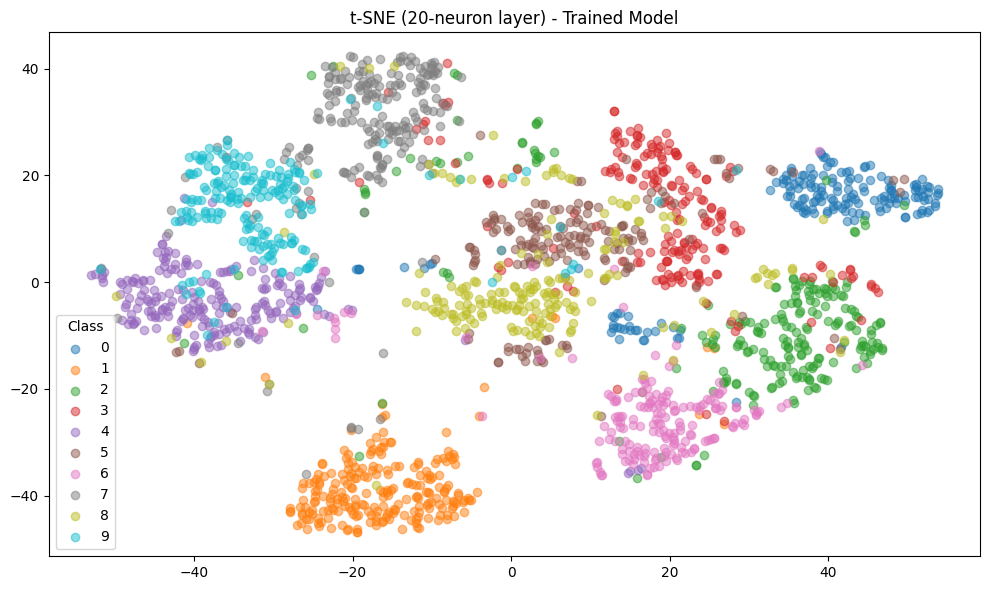

In [61]:
print("MLP untrained with relu")
mlp_untrained_relu = MLP_relu().to(device)

visualize_tsne(mlp_untrained_relu, test_X, test_y, trained=False, device=device)
print("MLP untrained with sigmoid")
mlp_untrained_sigmoid = MLP_sigmoid().to(device)
visualize_tsne(mlp_untrained_sigmoid, test_X, test_y, trained=False, device=device)
print("MLP trained with relu")
visualize_tsne(mlp_relu, test_X, test_y, trained=True, device=device)
print("MLP trained with sigmoid")
visualize_tsne(mlp_sigmoid, test_X, test_y, trained=True, device=device)


# t-SNE Comparison

t-SNE is a non linear dimensionality technique which is used to map high dimensional data to a 2d or 3d space for better visualisation. Observing the plots for the untrained MLPs (ReLU and Sigmoid), we see that there are no clusters and patterns. However, after training, there is clustering of each of the 10 classes, with very few outliers.


MLP on Fashion-MNIST
Accuracy: 0.0662, F1-score: 0.0457


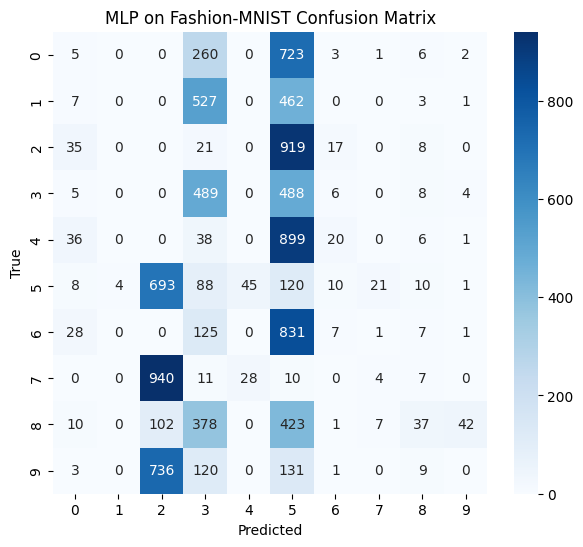

Test Loss: 30.0740


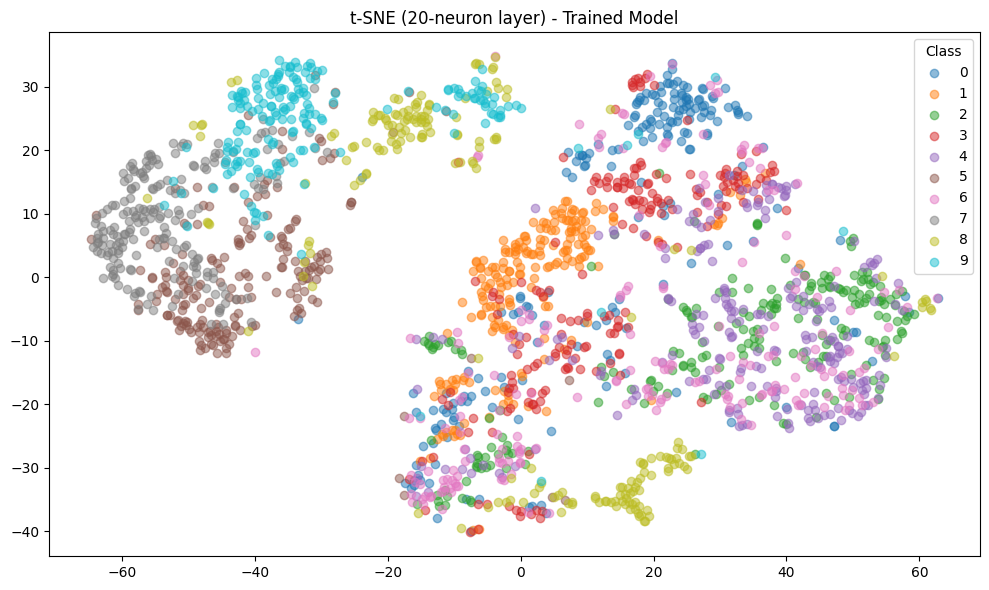

In [62]:
(f_train_X, f_train_y), (f_test_X, f_test_y) = fashion_mnist.load_data()
f_test_X = torch.from_numpy(f_test_X.reshape(-1, 784)).float() / 255
f_test_y = torch.from_numpy(f_test_y).to(torch.int64)

preds_f, acc_f, f1_f, cm_f, test_loss_f = evaluate_model(mlp_relu, f_test_X, f_test_y, device)
summary("MLP on Fashion-MNIST", acc_f, f1_f, cm_f)
print(f"Test Loss: {test_loss_f:.4f}")

visualize_tsne(mlp_relu, f_test_X, f_test_y, trained=True, device=device)



Testing MLP (Sigmoid) on Fashion-MNIST...

MLP on Fashion-MNIST
Accuracy: 0.1123, F1-score: 0.0623


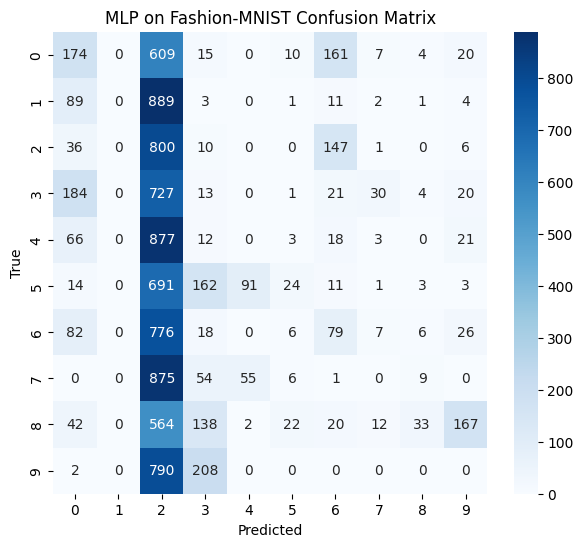

Test Loss: 4.1060


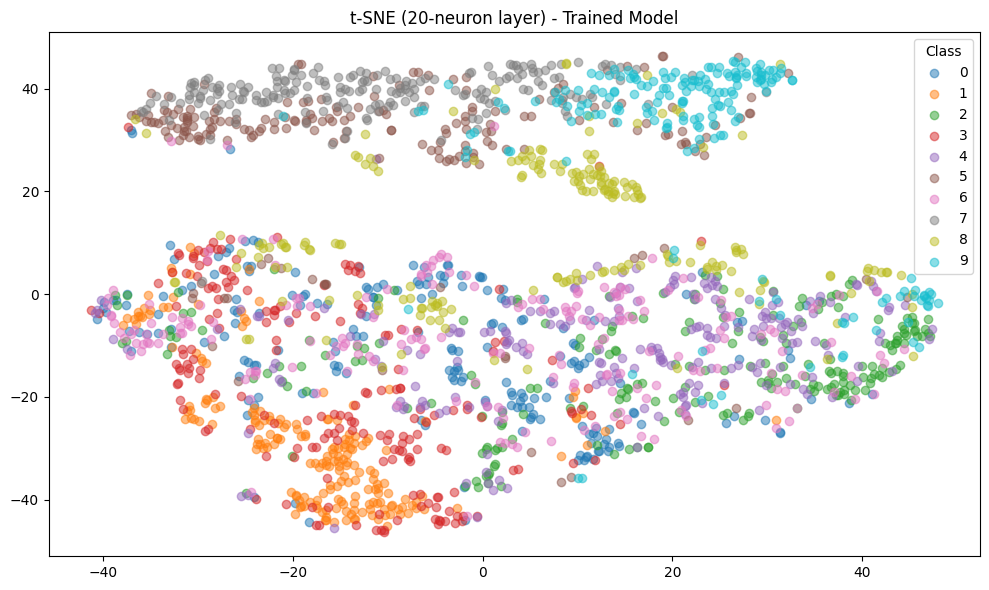

In [63]:
print("\nTesting MLP (Sigmoid) on Fashion-MNIST...")

(f_train_X, f_train_y), (f_test_X, f_test_y) = fashion_mnist.load_data()
f_test_X = torch.from_numpy(f_test_X.reshape(-1, 784)).float() / 255
f_test_y = torch.from_numpy(f_test_y).to(torch.int64)

preds_f, acc_f, f1_f, cm_f, test_loss_f = evaluate_model(mlp_sigmoid, f_test_X, f_test_y, device)
summary("MLP on Fashion-MNIST", acc_f, f1_f, cm_f)
print(f"Test Loss: {test_loss_f:.4f}")

visualize_tsne(mlp_sigmoid, f_test_X, f_test_y, trained=True, device=device)


# Testing Trained MLP on Fashion MNIST

The Fashion MNIST dataset is also similar to the MNIST dataset with it having images of size 28 x 28 and 10 output classes. When we use our trained MLPs on Fashion MNIST, we get very poor accuracy of around 11% with ReLU as activation and 6.6% wit Sigmoid as activation. We can get better results, by freezing the curren embeddings and adding 1 or 2 more layers and training it for a few epochs. From the t-SNE plot, there is no visible clustering of data which suggests no important features have been learnt. Moreover, both MLPs seem to be predict class 2 much more than any class.

# Summary of Results for Question 1

| Model            | Activation Function | Accuracy | F1 Score |
|----------------------------|--------------------|-----------|-----------|
| **MLP (ReLU)**             | ReLU               |       0.9621    |   0.9618        |
| **MLP (Sigmoid)**          | Sigmoid            |  0.9325         |0.9314           |
| **Random Forest**          | N/A                |     0.9704      |    0.9702       |
| **Logistic Regression**    | Sigmoid            |     0.9256      | 0.9245          |

## Fashion MNIST

| Model           | Activation | Accuracy  |
|-----------------|-------------|--------------|
| **MLP (ReLU)**  | ReLU        | 0.1123      |
| **MLP (Sigmoid)** | Sigmoid    | 0.0662       |



We observe that the best performing model is the random forest model, closely followed by the MLP with ReLU ,MLP with Sigmoid with Logistic Regression performing the worst.This could be explained by the fact that there are only 2 hidden layers and the number of neurons are less. We also observe Logistic Regression performs significantly worse than the others as it can only learn a linear boundary. Moreover, these models do not give any importance to the spaciality of images, and treat each pixel as individiual features. Thus, we would be able to achieve higher accuracy with CNNS as they will be able to capture local features like corners and edges. We observe many misclassifications, specifically with 2 and 7, which could be attributed to the fact that there is no inherent ordering of pixels in the above models



# Comparison of t-SNE plots of MNIST and Fashion MNIST

In the t-SNE plot of the 20 neuron layer for the Fashion MNIST dataset, there is no proper clustering visible, which suggests that the required features haven't been learnt and the model is unable to distinguish between the various classes. However, there is a clear and visible clustering in the t-SNE plot for the model trained on the MNIST dataset. We can conclude that the feature representations learnt on MNIST do not transfer well to the Fashion MNIST dataset. We can achieve higher accuracy by freezing the current model, and adding 1-2 more layers and training the model for a few epochs on the Fashion MNIST dataset

In [64]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32*13*13, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1,1,28,28)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32*13*13)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [65]:
cnn = CNN().to(device)
opt = optim.Adam(cnn.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


In [66]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64
train_dataset = TensorDataset(train_X, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
for epoch in range(100):
    cnn.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        opt.zero_grad()
        out = cnn(X_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/100, Loss: {avg_loss:.4f}")


Epoch 1/100, Loss: 0.2182
Epoch 2/100, Loss: 0.0685
Epoch 3/100, Loss: 0.0466
Epoch 4/100, Loss: 0.0336
Epoch 5/100, Loss: 0.0247
Epoch 6/100, Loss: 0.0187
Epoch 7/100, Loss: 0.0150
Epoch 8/100, Loss: 0.0118
Epoch 9/100, Loss: 0.0089
Epoch 10/100, Loss: 0.0065
Epoch 11/100, Loss: 0.0058
Epoch 12/100, Loss: 0.0063
Epoch 13/100, Loss: 0.0041
Epoch 14/100, Loss: 0.0050
Epoch 15/100, Loss: 0.0029
Epoch 16/100, Loss: 0.0044
Epoch 17/100, Loss: 0.0047
Epoch 18/100, Loss: 0.0029
Epoch 19/100, Loss: 0.0009
Epoch 20/100, Loss: 0.0041
Epoch 21/100, Loss: 0.0007
Epoch 22/100, Loss: 0.0027
Epoch 23/100, Loss: 0.0034
Epoch 24/100, Loss: 0.0008
Epoch 25/100, Loss: 0.0002
Epoch 26/100, Loss: 0.0037
Epoch 27/100, Loss: 0.0024
Epoch 28/100, Loss: 0.0007
Epoch 29/100, Loss: 0.0010
Epoch 30/100, Loss: 0.0030
Epoch 31/100, Loss: 0.0018
Epoch 32/100, Loss: 0.0004
Epoch 33/100, Loss: 0.0010
Epoch 34/100, Loss: 0.0000
Epoch 35/100, Loss: 0.0000
Epoch 36/100, Loss: 0.0000


Epoch 37/100, Loss: 0.0000
Epoch 38/100, Loss: 0.0000
Epoch 39/100, Loss: 0.0000
Epoch 40/100, Loss: 0.0000
Epoch 41/100, Loss: 0.0000
Epoch 42/100, Loss: 0.0023
Epoch 43/100, Loss: 0.0046
Epoch 44/100, Loss: 0.0008
Epoch 45/100, Loss: 0.0002
Epoch 46/100, Loss: 0.0000
Epoch 47/100, Loss: 0.0000
Epoch 48/100, Loss: 0.0000
Epoch 49/100, Loss: 0.0000
Epoch 50/100, Loss: 0.0000
Epoch 51/100, Loss: 0.0000
Epoch 52/100, Loss: 0.0000
Epoch 53/100, Loss: 0.0000
Epoch 54/100, Loss: 0.0000
Epoch 55/100, Loss: 0.0000
Epoch 56/100, Loss: 0.0000
Epoch 57/100, Loss: 0.0000
Epoch 58/100, Loss: 0.0000
Epoch 59/100, Loss: 0.0000
Epoch 60/100, Loss: 0.0000
Epoch 61/100, Loss: 0.0000
Epoch 62/100, Loss: 0.0000
Epoch 63/100, Loss: 0.0000
Epoch 64/100, Loss: 0.0000
Epoch 65/100, Loss: 0.0000
Epoch 66/100, Loss: 0.0090
Epoch 67/100, Loss: 0.0007
Epoch 68/100, Loss: 0.0001
Epoch 69/100, Loss: 0.0000
Epoch 70/100, Loss: 0.0000
Epoch 71/100, Loss: 0.0000
Epoch 72/100, Loss: 0.0000
Epoch 73/100, Loss: 0.0000
E


Simple CNN
Accuracy: 0.9851, F1-score: 0.9850


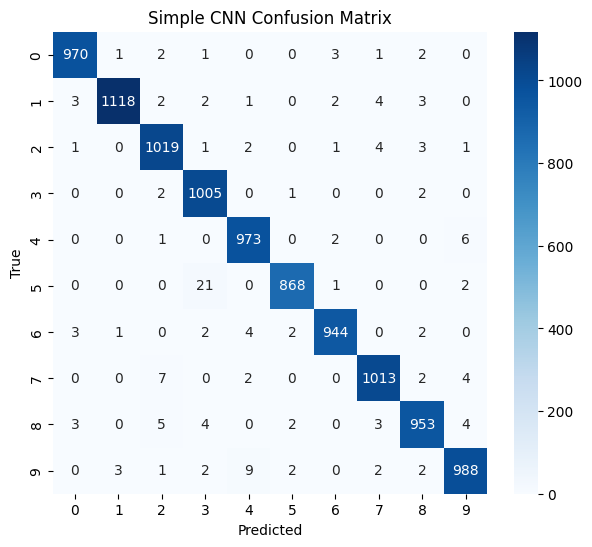

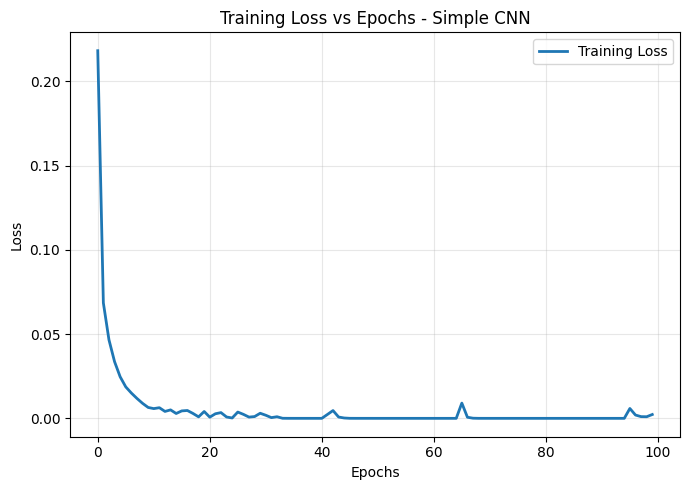

Params: 693,962, Inference time: 0.0006s, Test Loss: 0.1167


In [67]:
preds, acc_cnn, f1_cnn, cm_cnn, test_loss_cnn = evaluate_model(cnn, test_X, test_y, device)
params_cnn = sum(p.numel() for p in cnn.parameters())

start = time.time()
with torch.no_grad():
    _ = cnn(test_X[:512].to(device))
t_cnn = time.time() - start

summary("Simple CNN", acc_cnn, f1_cnn, cm_cnn, train_losses)
print(f"Params: {params_cnn:,}, Inference time: {t_cnn:.4f}s, Test Loss: {test_loss_cnn:.4f}")


Training MobileNetV2 (fine-tuned with 2 layers)...
Epoch 1/10 Loss: 0.3012
Epoch 2/10 Loss: 0.1365
Epoch 3/10 Loss: 0.1097
Epoch 4/10 Loss: 0.0922
Epoch 5/10 Loss: 0.0826
Epoch 6/10 Loss: 0.0742
Epoch 7/10 Loss: 0.0709
Epoch 8/10 Loss: 0.0650
Epoch 9/10 Loss: 0.0561
Epoch 10/10 Loss: 0.0474

MobileNetV2 (fine-tuned)
Accuracy: 0.9721, F1-score: 0.9721


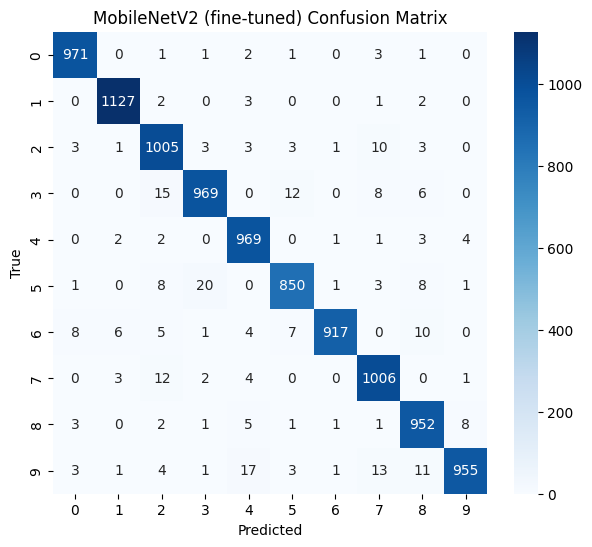

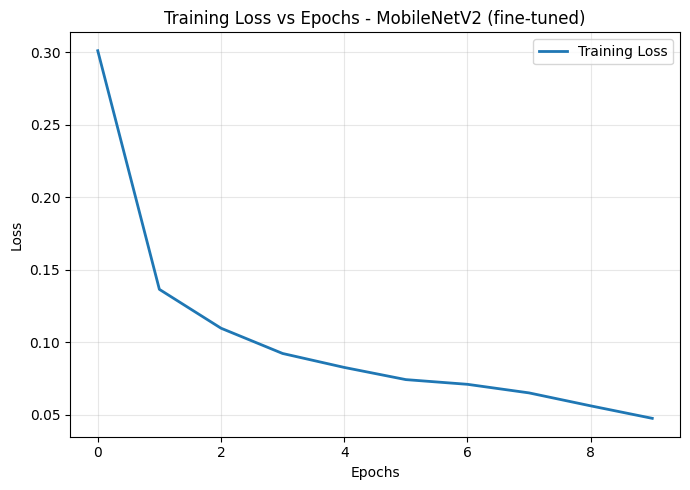

Params: 2,585,994, Inference time: 0.0059s, Test Loss: 0.1047
Epoch 1/10 Loss: 0.3345
Epoch 2/10 Loss: 0.1747
Epoch 3/10 Loss: 0.1461
Epoch 4/10 Loss: 0.1220
Epoch 5/10 Loss: 0.1081
Epoch 6/10 Loss: 0.0986


Epoch 7/10 Loss: 0.0910
Epoch 8/10 Loss: 0.0814
Epoch 9/10 Loss: 0.0784
Epoch 10/10 Loss: 0.0728

EfficientNet_B0 (fine-tuned)
Accuracy: 0.9730, F1-score: 0.9730


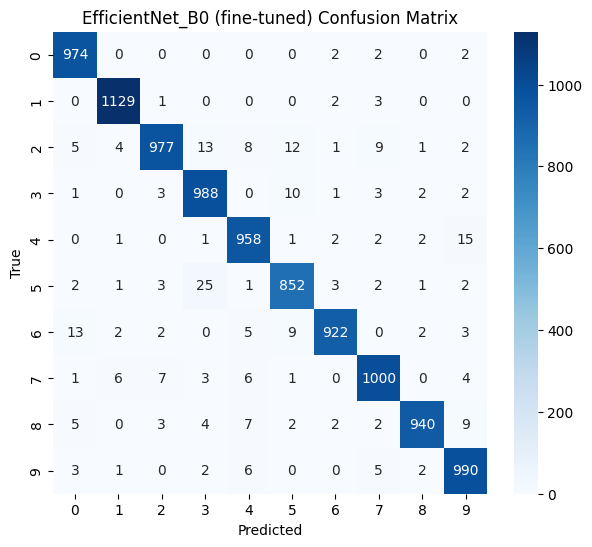

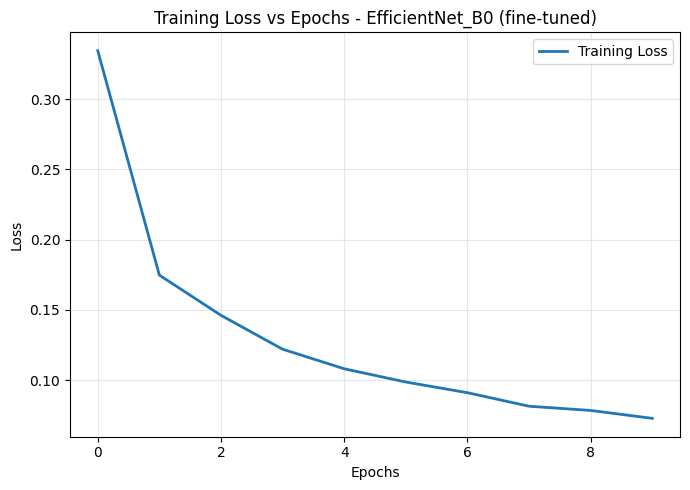

Params: 4,369,670, Inference time: 0.0084s, Test Loss: 0.0921


In [68]:


batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def preprocess_batch(Xb):
    Xb = Xb.to(device)
    
    Xb = Xb.repeat(1, 3, 1, 1)
    Xb = F.interpolate(Xb, size=(224, 224), mode='bilinear', align_corners=False)
    
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
    Xb = (Xb - mean) / std  
    return Xb

def evaluate_model_in_batches(model, X, y, batch_size, device):
    model.eval()  
    preds = []
    true_labels = []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    # Create batches
    for i in range(0, len(X), batch_size):
        Xb = X[i:i + batch_size].to(device)  
        yb = y[i:i + batch_size].to(device)
        Xb = preprocess_batch(Xb)
        with torch.no_grad():
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            total_loss += loss.item() * len(Xb)
        preds.append(outputs.argmax(dim=1).cpu().numpy())  
        true_labels.append(yb.cpu().numpy())
    preds = np.concatenate(preds)
    true_labels = np.concatenate(true_labels)
    acc = (preds == true_labels).mean()
    f1 = f1_score(true_labels, preds, average='weighted')
    cm = confusion_matrix(true_labels, preds)
    
    avg_loss = total_loss / len(X)
    
    return preds, acc, f1, cm, avg_loss

# --- Fine-tune MobileNetV2 ---
mobilenet = models.mobilenet_v2(weights="IMAGENET1K_V1")
for p in mobilenet.parameters():
    p.requires_grad = False
in_features = mobilenet.classifier[-1].in_features
mobilenet.classifier = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
mobilenet = mobilenet.to(device)

opt_m = optim.Adam(filter(lambda p: p.requires_grad, mobilenet.parameters()), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

X_train = train_X.reshape(-1,1,28,28)
y_train = train_y
train_losses_m = []

print("\nTraining MobileNetV2 (fine-tuned with 2 layers)...")
for epoch in range(10):
    mobilenet.train()
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        Xb = X_train[i:i+batch_size].to(device)
        yb = y_train[i:i+batch_size].to(device)
        Xb = preprocess_batch(Xb)
        opt_m.zero_grad()
        out = mobilenet(Xb)
        loss = loss_fn(out, yb)
        loss.backward()
        opt_m.step()
        total_loss += loss.item() * len(Xb)
    avg_loss = total_loss / len(X_train)
    train_losses_m.append(avg_loss)
    print(f"Epoch {epoch+1}/10 Loss: {avg_loss:.4f}")
preds_m, acc_m, f1_m, cm_m, test_loss_m = evaluate_model_in_batches(mobilenet, test_X.reshape(-1,1,28,28), test_y, batch_size, device)
summary("MobileNetV2 (fine-tuned)", acc_m, f1_m, cm_m, train_losses=train_losses_m)
params_m = sum(p.numel() for p in mobilenet.parameters())
start = time.time()
with torch.no_grad():
    _ = mobilenet(preprocess_batch(test_X[:256].reshape(-1,1,28,28).to(device)))
t_m = time.time() - start
print(f"Params: {params_m:,}, Inference time: {t_m:.4f}s, Test Loss: {test_loss_m:.4f}")
efficient = models.efficientnet_b0(weights="IMAGENET1K_V1")
for p in efficient.parameters():
    p.requires_grad = False
last_layer = efficient.classifier[-1]
if isinstance(last_layer, nn.Linear):
    in_features = last_layer.in_features
else:
    in_features = last_layer[1].in_features
efficient.classifier = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
efficient = efficient.to(device)

opt_e = optim.Adam(filter(lambda p: p.requires_grad, efficient.parameters()), lr=1e-3)
train_losses_e = []
for epoch in range(10):
    efficient.train()
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        Xb = X_train[i:i+batch_size].to(device)
        yb = y_train[i:i+batch_size].to(device)
        Xb = preprocess_batch(Xb)
        opt_e.zero_grad()
        out = efficient(Xb)
        loss = loss_fn(out, yb)
        loss.backward()
        opt_e.step()
        total_loss += loss.item() * len(Xb)
    avg_loss = total_loss / len(X_train)
    train_losses_e.append(avg_loss)
    print(f"Epoch {epoch+1}/10 Loss: {avg_loss:.4f}")
preds_e, acc_e, f1_e, cm_e, test_loss_e = evaluate_model_in_batches(efficient, test_X.reshape(-1,1,28,28), test_y, batch_size, device)
summary("EfficientNet_B0 (fine-tuned)", acc_e, f1_e, cm_e, train_losses=train_losses_e)
params_e = sum(p.numel() for p in efficient.parameters())
start = time.time()
with torch.no_grad():
    _ = efficient(preprocess_batch(test_X[:256].reshape(-1,1,28,28).to(device)))
t_e = time.time() - start
print(f"Params: {params_e:,}, Inference time: {t_e:.4f}s, Test Loss: {test_loss_e:.4f}")




# Summary of Question 2
| Model                  | Accuracy  | F1 Score | Inference Time (s / 256 imgs) | Parameters  |
|-------------------------|-----------|-----------|-------------------------------|--------------|
| **CNN**                 | 0.9851    | 0.9850    | 0.0006                        | 693962       |
| **MobileNetV2**         | 0.9721    | 0.9721    | 0.0059                        | 2585994      |
| **EfficientNet_B0**     | 0.9730    | 0.9730    | 0.0084                        | 4369670      |


We observe that the CNN achieved the highest accuracy across all models, while also having the least inference time and parameters. The F1-Score was also highest for the CNN.

For the pretrained models,  there are 1000 labels and we need to predict for 10 output labels. Thus, we perform transfer learning by removing the last layer, and replacing it with 2 hidden layers and an output layer of 10 neurons. We then fine tuned the model by training it on the train dataset for 10 epochs. We have used MobileNetV2 and EfficicentNet_B0. Although these are supposed to be very powerful pretrained models with high number of parametrs, they do not perform as well on the MNIST dataset as they are trained for recognizing features from complex RGB images. These features may not translate into the simple and limited features in the MNIST dataset. However, a simple CNN can learn these features from scratch very easily leading to better accuracy, while having much lesser number of parameters.